In [1]:
#####Hierarchical Gaussian Process Regression model####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns

#np.random.seed(98537)

In [2]:
###乱数を生成する関数を設定####
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

##多変量正規分布の乱数を生成する関数
def rmvnorm(mu, Cov, hh, k):
    s = mu + np.random.normal(0, 1, hh*k).reshape(hh, k)
    P = np.linalg.cholesky(Cov)
    y = np.dot(P, s.T).T
    return y

##任意の相関行列を作る関数
def CorM(col, lower, upper, eigen_lower, eigen_upper, pattern):
    #相関行列の初期値を定義する
    if pattern==1:
        Prob = np.abs(lower) / (np.abs(lower) + np.abs(upper))
        z = np.random.binomial(1, Prob, col*col); z[z==0] = -1
        cov_vec = np.random.beta(1.0, 3.0, col*col) * z   #相関係数の乱数ベクトルを作成
    else:
        cov_vec = np.random.uniform(lower, upper, col*col)   #相関係数の乱数ベクトルを作成
    rho = np.tril(cov_vec.reshape(col, col), k=-1)   #乱数ベクトルを下三角行列化
    Sigma = (rho + rho.T) + np.diag(np.repeat(1, col))   #対角成分を1にする
    
    #相関行列を正定値行列に変更
    #固有値分解を実行
    eigen = np.linalg.eigh(Sigma)
    eigen_val = eigen[0] 
    eigen_vec = eigen[1]
    
    #固有値が負の数値を正にする
    for i in range(col):
        if eigen_val[i] < 0:
            eigen_val[i] = np.random.uniform(eigen_lower, eigen_upper, 1)
            
    #新しい相関行列の定義と対角成分を1にする
    Sigma = np.dot(np.dot(eigen_vec, np.diag(eigen_val)), eigen_vec.T)
    normalization_factor = np.dot(np.power(np.diag(Sigma), 0.5)[:, np.newaxis], np.power(np.diag(Sigma), 0.5)[np.newaxis, :])
    Cor = Sigma / normalization_factor
    return Cor

##相関行列から分散共分散行列に変換する関数
def covmatrix(Cor, sigma_lower, sigma_upper):
    sigma = (sigma_upper - sigma_lower) * rand(np.diag(Cor).shape[0]) + sigma_lower
    sigma_factor = np.dot(sigma[:, np.newaxis], sigma[np.newaxis, :])
    Cov = Cor * sigma_factor
    return Cov

##分散共分散行列から相関行列に変換する関数
def cov2cor(Cov):
    D = np.diag(np.power(np.diag(Cov), -1/2))
    corr = np.dot(np.dot(D, Cov), D)
    return corr

336890


(array([ 20.,  93., 220., 436., 518., 648., 613., 670., 495., 376., 345.,
        200., 116., 109.,  62.,  28.,  24.,  16.,   5.,   1.,   1.,   1.,
          1.,   0.,   2.]),
 array([ 15.  ,  22.28,  29.56,  36.84,  44.12,  51.4 ,  58.68,  65.96,
         73.24,  80.52,  87.8 ,  95.08, 102.36, 109.64, 116.92, 124.2 ,
        131.48, 138.76, 146.04, 153.32, 160.6 , 167.88, 175.16, 182.44,
        189.72, 197.  ]),
 <a list of 25 Patch objects>)

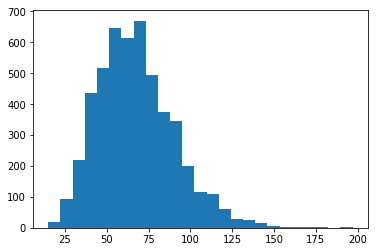

In [3]:
####データの発生####
##データの設定
type_n = 3
hh = 5000
pt = np.random.poisson(np.random.gamma(10.0, 1/0.15, hh), hh)
pt[pt <= 5] = 5
hhpt = np.sum(pt)
print(hhpt)
plt.hist(pt, bins=25)

In [4]:
##IDとインデックスを作成
#IDの作成
user_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(hhpt))
user_list = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
user_dt = sparse.coo_matrix((np.repeat(1, hhpt), (user_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [5]:
##説明変数の生成
##素性ベクトルを生成
k1 = 4; k2 = 5; k3 = 4
x1 = np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1))
x2 = np.zeros((hhpt, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, hhpt)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3), axis=1)
x_col = x.shape[1]

In [6]:
##階層モデルのカーネルを生成
#データとパラメータの設定
k = 30
v = 450
w = np.random.poisson(np.random.gamma(15.0, 1/0.2, hh), hh)
theta = np.random.dirichlet(np.repeat(0.2, k), hh)
phi = np.random.dirichlet(np.repeat(0.1, v), k)

#データの生成
W = np.array(np.zeros((hh, v)), dtype="float64")
for i in range(hh):
    Z = np.random.multinomial(1, theta[i, ], w[i])
    z_vec = np.dot(Z, np.arange(k))
    W[i, ] = np.array(np.sum(np.array(rmnom(phi[z_vec, ], w[i], v, np.arange(w[i])).todense()), axis=0) > 0)
    
#カーネルの設定
K = CorM(hh, 0.0, 1.0, 0.01, 0.1, 0)
inv_K = np.linalg.inv(K)

In [7]:
##応答変数を生成
#パラメータを生成
mu = np.append(-1.0, np.repeat(0, x_col-1))
tau = np.append(4.5, np.random.uniform(1.5, 4.5, x_col-1))
theta = np.zeros((hh, x_col))
for j in range(x_col):
    print(j)
    theta[:, j] = np.random.multivariate_normal(np.repeat(mu[j], hh), tau[j]*K, 1)
mut = mu.copy(); taut = tau.copy(); thetat = theta.copy()

#ロジスティック回帰モデルから応答変数を生成
logit = np.dot(x * theta[user_id, ], np.repeat(1, x_col))
Prob = np.exp(logit) / (1 + np.exp(logit))
y = np.random.binomial(1, Prob, hhpt)
y_vec = y[:, np.newaxis]

0
1
2
3
4
5
6
7
8
9
10
11
12


0.4401080471370477


(array([90413., 21157., 13863., 10609.,  8758.,  7519.,  6770.,  6258.,
         5895.,  5632.,  5385.,  5366.,  5235.,  5329.,  5166.,  5376.,
         5620.,  5946.,  6307.,  6788.,  7669.,  9133., 11367., 16758.,
        58571.]),
 array([1.92348788e-09, 4.00000018e-02, 8.00000017e-02, 1.20000002e-01,
        1.60000001e-01, 2.00000001e-01, 2.40000001e-01, 2.80000001e-01,
        3.20000001e-01, 3.60000001e-01, 4.00000001e-01, 4.40000001e-01,
        4.80000001e-01, 5.20000000e-01, 5.60000000e-01, 6.00000000e-01,
        6.40000000e-01, 6.80000000e-01, 7.20000000e-01, 7.60000000e-01,
        8.00000000e-01, 8.39999999e-01, 8.79999999e-01, 9.19999999e-01,
        9.59999999e-01, 9.99999999e-01]),
 <a list of 25 Patch objects>)

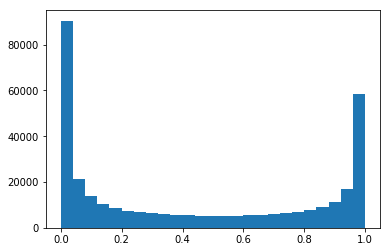

In [8]:
#データの確認
print(np.mean(y))
plt.hist(Prob, bins=25)

In [9]:
####マルコフ連鎖モンテカルロ法でモデルを推定####
##アルゴリズムの設定
R = 2000
keep = 4
burnin = int(500/keep)
iter = 0
disp = 10
e = 0.05
L = 3

In [10]:
##パラメータ推定のための関数を定義
#多変量正規分布の条件付き期待値と分散を計算する関数
def cdMVN(mu, Cov, department, U):

    #分散共分散行列のブロック行列を定義
    index = np.delete(np.arange(Cov.shape[0]), department)
    Cov11 = Cov[department, ][:, department]
    Cov12 = Cov[department, ][:, index]
    Cov21 = Cov[:, department][index, ]
    Cov22 = Cov[index, ][:, index]

    #条件付き分散と条件付き平均を計算
    inv_Cov22 = np.linalg.inv(Cov22)
    CDinv = np.dot(Cov12, inv_Cov22)
    CDmu = mu[:, department] + np.dot(CDinv, (U[:, index] - mu[:, index]).T).T   #条件付き平均
    CDvar = Cov11 - np.dot(np.dot(Cov12, inv_Cov22), Cov21)   #条件付き分散
    return CDmu, CDvar

#対数事後分布を計算する関数
def loglike(theta, y, x, mu, tau, inv_Cov, user_id, k):
    #ロジットモデルの対数尤度
    logit = np.exp(np.dot(x * theta[user_id, ], np.repeat(1, k)))
    Prob = logit / (1 + logit)
    LLi_logit = y*np.log(Prob) + (1-y)*np.log(1-Prob)   #ロジットモデルの対数尤度   

    #多変量正規分布の対数事前分布
    er = thetat - np.full((hh, k), mu)
    LLi_mvn = np.sum(-1/2 * 1/tau * np.sum(np.dot(er.T, inv_K) * er.T, axis=1))

    #対数事後分布の和
    Posterior = np.sum(LLi_logit) + LLi_mvn
    return Posterior

#対数事後分布の微分関数
def dloglike(theta, y, x, mu, tau, inv_Cov, user_id, user_list, hh, k):
    #ロジットモデルの応答確率
    logit = np.exp(np.dot(x * theta[user_id, ], np.repeat(1, k)))
    Prob = logit / (1 + logit)

    #微分関数の設定
    er = theta - np.full((hh, k), mu)
    dlogit = y[:, np.newaxis]*x - Prob[:, np.newaxis]*x   #ロジットモデルの対数尤度の微分関数
    dmvn = -1/tau * np.dot(inv_K, er)   #多変量正規分布の対数事前分布の微分関数

    #勾配ベクトルの設定
    dlogit_sums = np.zeros((hh, k))
    for i in range(hh):
        dlogit_sums[i, ] = np.sum(dlogit[user_list[i], ], axis=0)
    LLd = -dlogit_sums# - dmvn
    return LLd

##リープフロッグ法を解く関数
def leapfrog(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, y, x, mu, tau, inv_K, user_id, user_list, hh, x_col) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, y, x, mu, tau, inv_K, user_id, user_list, hh, x_col) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [11]:
##パラメータの事前分布を設定
#階層モデルの分散の事前分布
s0 = 0.1
v0 = 0.1

#階層モデルの平均の事前分布
alpha0 = 0
tau0 = 100
inv_tau0 = 1/tau0

In [539]:
##パラメータの真値の設定
#階層モデルのパラメータの真値
mu = mut.copy()
tau = taut.copy()

#モデルパラメータの真値
theta = thetat.copy()

In [540]:
##パラメータの初期値の設定
#階層モデルのパラメータの初期値
mu = np.append(-0.5, np.repeat(0, x_col-1))
tau = np.repeat(10.0, x_col)

#モデルパラメータの初期値
theta = np.random.multivariate_normal(mu, np.diag(np.repeat(0.5, x_col)), hh)

In [541]:
##パラメータの格納用配列
THETA = np.zeros((hh, x_col, int(R/keep)))
MU = np.zeros((int(R/keep), x_col))
TAU = np.zeros((int(R/keep), x_col))

In [542]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
Prob = np.mean(y)
LLst = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))
print(LLst)

#真値の対数尤度
logit = np.dot(x * thetat[user_id, :], np.repeat(1, x_col))
Prob = np.exp(logit) / (1 + np.exp(logit))
LLbest = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))
print(LLbest)

-232107.26621714118
-98732.7275351067


In [543]:
####HMCでパラメータをサンプリング####
for rp in range(R):
    
    #HMCの新しいパラメータを生成
    rold = np.random.multivariate_normal(np.repeat(0, x_col), np.diag(np.ones(x_col)), hh)
    thetad = theta.copy()

    #リープフロッグ法による1ステップ移動
    res = leapfrog(rold, thetad, dloglike, e, L)
    rnew = res[0]
    thetan = res[1]

    #移動前と移動後のハミルトニアン
    Hnew = -loglike(thetan, y, x, mu, tau, inv_K, user_id, x_col) + np.sum(np.power(rnew, 2)) / 2
    Hold = -loglike(thetad, y, x, mu, tau, inv_K, user_id, x_col) + np.sum(np.power(rold, 2)) / 2

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, 1)
    accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率

    #採択率に基づきgammaを採択
    if(accept_prob >= rand):
        theta = thetan.copy()
    else:
        theta = thetad.copy()
        
        
    ##階層モデルのパラメータをサンプリング
    #平均ベクトルをサンプリング
    mu_vec = np.mean(theta, axis=0)
    weights = tau / (tau0/hh + tau)
    mu = np.random.normal(weights*mu_vec, weights*tau/hh, x_col)

    #分散をサンプリング
    s = np.sum(np.power(theta - np.full((hh, x_col), mu_vec), 2), axis=0) + s0
    v = hh + v0
    tau = 1/np.random.gamma(v/2, 1/(s/2))
        

    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        THETA[:, :, mkeep] = theta
        MU[mkeep, ] = mu
        TAU[mkeep, ] = tau

    if rp%disp==0:
        #対数尤度の計算
        logit = np.dot(x * theta[user_id, :], np.repeat(1, x_col))
        Prob = np.exp(logit) / (1 + np.exp(logit))
        LL = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))

        #サンプリング結果の表示
        print(rp)
        print(accept_prob)
        print(np.round(np.array((LL, LLbest, LLst)), 1))

0
1.0
[-290681.4  -98732.7 -232107.3]
10
1.0
[-191009.5  -98732.7 -232107.3]
20
1.0
[-170943.1  -98732.7 -232107.3]
30
1.0
[-160678.2  -98732.7 -232107.3]
40
1.0
[-153325.6  -98732.7 -232107.3]
50
0.8007502426740306
[-147803.   -98732.7 -232107.3]
60
1.0
[-143268.8  -98732.7 -232107.3]
70
1.0
[-139507.7  -98732.7 -232107.3]
80
1.0
[-136096.6  -98732.7 -232107.3]
90
1.0
[-133611.7  -98732.7 -232107.3]
100
0.9141656374166232
[-131263.1  -98732.7 -232107.3]
110
1.0
[-129548.1  -98732.7 -232107.3]
120
1.0
[-127669.8  -98732.7 -232107.3]
130
0.8883067818885435
[-125833.5  -98732.7 -232107.3]
140
1.0
[-124286.5  -98732.7 -232107.3]
150
0.854642482715981
[-122952.6  -98732.7 -232107.3]
160
1.0
[-121680.2  -98732.7 -232107.3]
170
0.8051941314290617
[-120417.9  -98732.7 -232107.3]
180
1.0
[-119452.4  -98732.7 -232107.3]
190
0.9320898095160092
[-118476.   -98732.7 -232107.3]
200
1.0
[-117619.8  -98732.7 -232107.3]
210
1.0
[-116857.   -98732.7 -232107.3]
220
1.0
[-116079.4  -98732.7 -232107.3]
23

C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal


1640
nan
[ -95722.6  -98732.7 -232107.3]
1650
nan
[ -95670.7  -98732.7 -232107.3]
1660
0.9492765272130624
[ -95714.6  -98732.7 -232107.3]
1670
nan
[ -95689.3  -98732.7 -232107.3]
1680
0.9957223630240052
[ -95636.4  -98732.7 -232107.3]
1690
0.9358179595993004
[ -95621.3  -98732.7 -232107.3]
1700
0.9598270505210589
[ -95594.1  -98732.7 -232107.3]
1710
0.882171457156868
[ -95600.5  -98732.7 -232107.3]
1720
1.0
[ -95507.5  -98732.7 -232107.3]
1730
1.0
[ -95399.8  -98732.7 -232107.3]
1740
1.0
[ -95301.1  -98732.7 -232107.3]
1750
0.9090192531750086
[ -95356.8  -98732.7 -232107.3]
1760
1.0
[ -95371.1  -98732.7 -232107.3]
1770
0.8965108765428883
[ -95346.4  -98732.7 -232107.3]
1780
1.0
[ -95368.2  -98732.7 -232107.3]
1790
1.0
[ -95347.6  -98732.7 -232107.3]
1800
0.9800031973724067
[ -95237.6  -98732.7 -232107.3]
1810
0.995290232707589
[ -95131.5  -98732.7 -232107.3]
1820
0.9152146552611607
[ -95151.5  -98732.7 -232107.3]
1830
1.0
[ -95018.2  -98732.7 -232107.3]
1840
1.0
[ -95075.9  -98732.7 -2

3420
0.9549529338749435
[ -92974.9  -98732.7 -232107.3]
3430
nan
[ -92982.7  -98732.7 -232107.3]
3440
nan
[ -92982.7  -98732.7 -232107.3]
3450
1.0
[ -92961.   -98732.7 -232107.3]


KeyboardInterrupt: 